Get SPY parquet intraday file at:
https://mega.nz/file/lXETlQBB#OvWnm7URTQaiBT1rYUna5Ya-t8EZcm-j3nD_PGhCcA0

Intraday momentum strategy based on Gaussian mixed model - Hidden markov model

In [3]:
import numpy as np
import pandas as pd
import quantstats as qs
import hmmlearn.hmm as hmm
import warnings
import random

warnings.filterwarnings('ignore')
random.seed(1)

In [4]:
def intraday_data(ticker = 'SPY', interval = '1h'):
    df = pd.read_parquet(f'{ticker}.parquet')
    df = df.reset_index()
    df = df.sort_values(by = 'datetime')
    df = df.set_index(['datetime'])
    df = df.drop('index', axis=1)
    
    if interval == 'original':
        return df
    else:
    
        df = df.between_time('09:30', '16:00')

        ohlc_dict = {                                                                                                        
            'open': 'first',                                                                                                    
            'high': 'max',                                                                                                       
            'low': 'min',                                                                                                        
            'close': 'last',                                                                                                    
            'volume': 'sum',
            }

        df = df.resample(interval, closed = 'left', label = 'left').apply(ohlc_dict).dropna()
    
        return df

def vwap(df):
    n = 78*5
    i = n
    large_vec = np.zeros(df.shape[0])
    while i < df.shape[0]:
        vec = df.iloc[(i-n):i]
        q = vec.volume
        p = vec.close
        large_vec[(i-n):i] = (p * q).cumsum() / q.cumsum()
        
        i = i + n
        
    return pd.Series(large_vec, index = df.index, name = 'vwap')

In [5]:
data = intraday_data('SPY', '1 min')
data = data.between_time('9:30', '16:00')
data['UnboundedDV2'] = (data.close / ((data.high.rolling(20).max() 
                                          + data.low.rolling(20).min())/2)).rolling(5).mean() - 1
n = np.floor(data.shape[0] * 0.75).astype(int)

s1 = vwap(data)
s1 = data.close / s1 - 1
s2 = np.log(data.close/data.close.shift(1)).dropna()
s3 = data.UnboundedDV2.rolling(252).rank(pct = True).dropna()

df = pd.concat([s1, s2, s3], axis = 1).dropna()
df.columns = ['vwap', 'y', 'dv2']
df = df[df.vwap != np.inf]

model = hmm.GMMHMM(n_components=3, n_iter=1000, algorithm = 'baum-welch', covariance_type ='full')
model = model.fit(df.iloc[:n,])
postProb = model.predict_proba(df.iloc[n:,])
df2 = pd.concat([pd.DataFrame(postProb, index = df.iloc[n:,].index), df.iloc[n:,]], axis = 1)

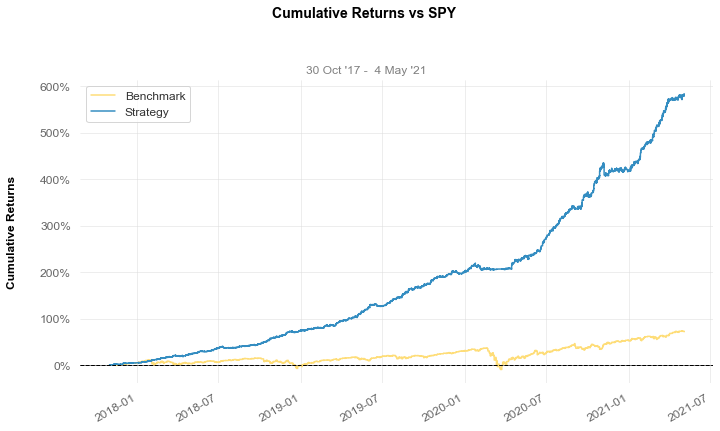

sharpe ratio: 5.81990909576416


In [21]:
strat = pd.DataFrame(np.where(df2[1] > 0.9, df2.y.shift(-1), 
                              np.where(df2[2]> 0.9, -df2.y.shift(-1), 0)), index = df2.index)

qs.plots.returns(strat, 'SPY')
print(f'sharpe ratio: {qs.stats.sharpe(strat, periods = 5*78*252)[0]}')